In [85]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [86]:
df = pd.read_excel('data/texaco_data.xlsx')
df1 = df.loc[df['C'] > 0][:17]
print(df1)

       n  fuel_rate  o2_fuel  steam_fuel  water_coal       C      H     O  \
0    I-1     76.660   0.8660       0.241         0.0  74.050  6.250  1.32   
1    I-2     81.180   0.7680       0.314         0.0  73.040  5.820  1.70   
2    I-3     82.202   0.8130       0.309         0.0  73.545  6.035  1.51   
3   I-4A     79.456   0.8070       0.323         0.0  73.545  6.035  1.51   
4   I-4B     81.846   0.7970       0.310         0.0  73.545  6.035  1.51   
5   I-5A     71.640   0.8263       0.352         0.0  73.545  6.035  1.51   
6   I-5B     65.000   0.8170       0.392         0.0  73.545  6.035  1.51   
7   I-5C     56.264   0.8320       0.429         0.0  73.545  6.035  1.51   
8    I-6     87.730   0.7740       0.291         0.0  73.545  6.035  1.51   
9   I-7A     90.974   0.7757       0.282         0.0  73.545  6.035  1.51   
10  I-7B     95.392   0.7820       0.267         0.0  73.545  6.035  1.51   
11  I-8A     92.130   0.7970       0.247         0.0  73.545  6.035  1.51   

In [87]:
def HHV_correlation(ultimate, ash): # Correlation from Silva et al. 2019 - 10.1016/j.rser.2019.109305
    A = ash * 100
    C = ultimate[0] / sum(ultimate) * (100 - A)
    H = ultimate[1] / sum(ultimate) * (100 - A)
    O = ultimate[2] / sum(ultimate) * (100 - A)
    N = ultimate[3] / sum(ultimate) * (100 - A)
    S = ultimate[4] / sum(ultimate) * (100 - A)
    Cl = ultimate[5] / sum(ultimate) * (100 - A)
    HHV = 0.3491*C + 1.1783*H + 0.1005*S - 0.1034*O - 0.0151*N - 0.0211*A
    return HHV
    

In [88]:
P = 24*ct.one_atm # 24 atm = 2 431 800 Pa
T0 = 230 + 273.15 # 450 °F = 230 °C = 503.15 # K
species = ['CO', 'H2', 'CO2', 'CH4', 'H2S', 'N2']
fracs = np.zeros((len(df1), len(species)))
rates = np.zeros((len(df1), len(species)))
c = 0

for i, row in df1.iterrows():
    # Fuel
    ultimate = [row['C'], row['H'], row['O'], row['N'], row['S'], row['Cl']]
    ash = row['ash'] / 100
    HHV = HHV_correlation(ultimate,ash)
    fuelRate = row['fuel_rate'] / 1000 # kg/s
    feed = fs.create_fuel_stream(fuelRate, ultimate, ash, moisture=0, HHV=HHV)

    # Gasifying agent
    oxyRatio = row['o2_fuel']
    steamRatio = row['steam_fuel']
    waterRatio = row['water_coal']

    oxygen = fs.create_O2_stream(oxyRatio*fuelRate)
    steam = fs.create_steam_stream(steamRatio*fuelRate)

    agent = fs.combine_streams(oxygen, steam)

    outlet_non = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)

    for j, sp in enumerate(species):
        fracs[c,j] = 100*outlet_non.get_syngas_fraction(sp, water=False, nitrogen=True) # % mol/mol
        rates[c,j] = outlet_non.species_moles[phases.indices[sp]] * phases.Mw[sp] * 1000 # g/s

    c += 1

In [89]:
exp_frac = df1[species]
avg_exp_frac = np.array(exp_frac.mean(0))
author_frac = df1[['CO_m', 'H2_m', 'CO2_m', 'CH4_m', 'H2S_m', 'N2_m']]
avg_author_frac = np.array(author_frac.mean(0))
avg_model_frac = np.mean(fracs, 0)

In [90]:
exp_rate = df1[['CO_f', 'H2_f', 'CO2_f', 'CH4_f', 'H2S_f', 'N2_f']]
avg_exp_rate = np.array(exp_rate.mean(0))
author_rate = df1[['CO_fm', 'H2_fm', 'CO2_fm', 'CH4_fm', 'H2S_fm', 'N2_fm']]
avg_author_rate = np.array(author_rate.mean(0))
avg_model_rate = np.mean(rates, 0)

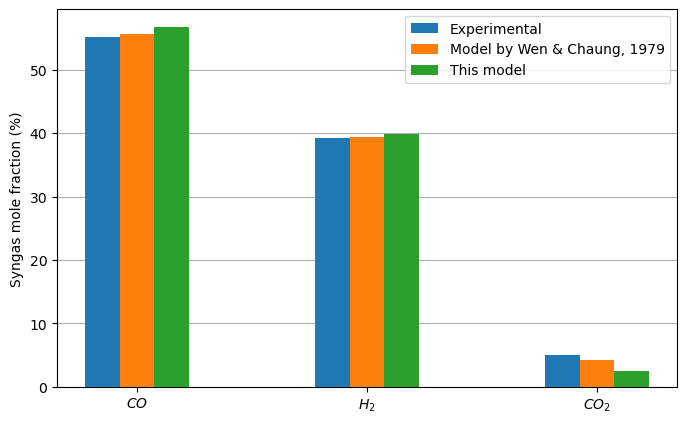

In [91]:
frac_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$', '$H_2S$','$N_2$']

X_axis1 = np.arange(len(frac_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1[:3] - w, avg_exp_frac[:3], w, label='Experimental', zorder=3)
ax1.bar(X_axis1[:3], avg_author_frac[:3], w, label='Model by Wen & Chaung, 1979', zorder=3)
ax1.bar(X_axis1[:3] + w, avg_model_frac[:3], w, label='This model', zorder=3)
ax1.set_ylabel("Syngas mole fraction (%)")
ax1.grid(zorder=0, axis='y')
plt.xticks(X_axis1[:3], frac_groups[:3])
# plt.yscale('log')
plt.legend(loc='best')
plt.savefig('figures/wen1.png')
plt.show()

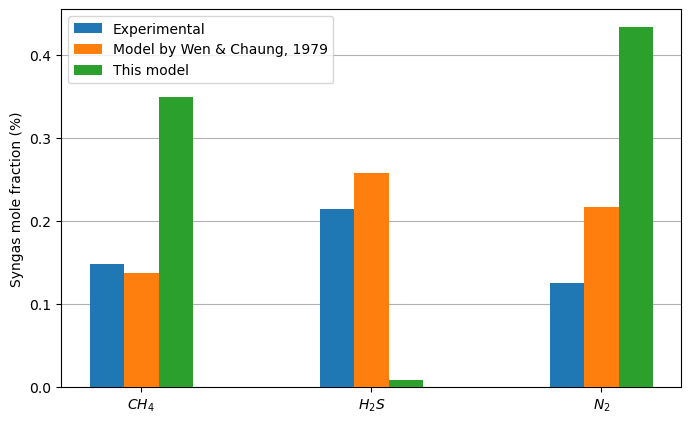

In [92]:
frac_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$', '$H_2S$','$N_2$']

X_axis1 = np.arange(len(frac_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1[3:6] - w, avg_exp_frac[3:6], w, label='Experimental', zorder=3)
ax1.bar(X_axis1[3:6], avg_author_frac[3:6], w, label='Model by Wen & Chaung, 1979', zorder=3)
ax1.bar(X_axis1[3:6] + w, avg_model_frac[3:6], w, label='This model', zorder=3)
ax1.set_ylabel("Syngas mole fraction (%)")
ax1.grid(zorder=0, axis='y')
plt.xticks(X_axis1[3:6], frac_groups[3:6])
# plt.yscale('log')
plt.legend(loc='best')
plt.savefig('figures/wen2.png')
plt.show()

In [93]:
print(avg_exp_frac)
print(avg_author_frac)
print(avg_model_frac)
print(abs(avg_model_frac - avg_exp_frac), np.mean(abs(avg_model_frac - avg_exp_frac)))
print(abs(avg_author_frac - avg_exp_frac), np.mean(abs(avg_author_frac - avg_exp_frac)))
print(abs((avg_model_frac - avg_exp_frac)/avg_exp_frac*100))


[55.26705882 39.20529412  4.99705882  0.14823529  0.21411765  0.12470588]
[55.63958824 39.49558824  4.26652941  0.13705882  0.25735294  0.21652941]
[5.67220341e+01 3.99023467e+01 2.57696591e+00 3.49292489e-01
 8.24992572e-03 4.33237583e-01]
[1.45497528 0.69705263 2.42009291 0.2010572  0.20586772 0.3085317 ] 0.8812629055135409
[0.37252941 0.29029412 0.73052941 0.01117647 0.04323529 0.09182353] 0.25659803921568664
[  2.63262657   1.77795536  48.43034668 135.63382212  96.14701271
 247.40749582]


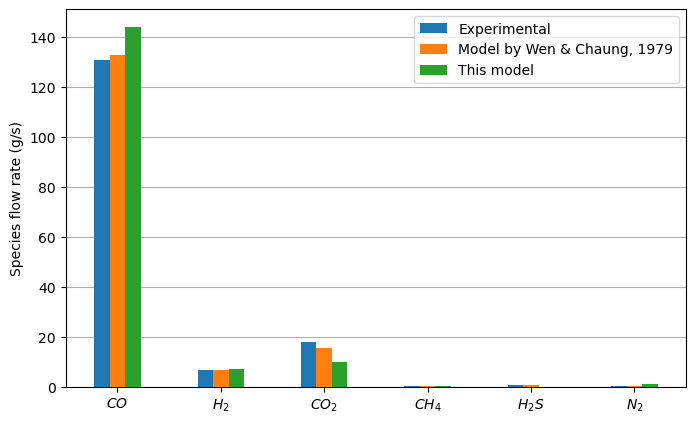

In [94]:
rate_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$', '$H_2S$','$N_2$']

X_axis1 = np.arange(len(rate_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1 - w, avg_exp_rate, w, label='Experimental', zorder=3)
ax1.bar(X_axis1, avg_author_rate, w, label='Model by Wen & Chaung, 1979', zorder=3)
ax1.bar(X_axis1 + w, avg_model_rate, w, label='This model', zorder=3)
ax1.set_ylabel("Species flow rate (g/s)")
ax1.grid(zorder=0, axis='y')
plt.xticks(X_axis1, rate_groups)
# plt.yscale('log')
plt.legend(loc='best')
plt.savefig('figures/wen3.png')
plt.show()

In [95]:
I1 = df[df['n'] == 'I-1']
ultimate = [float(I1['C']), float(I1['H']), float(I1['O']), float(I1['N']), float(I1['S']), float(I1['Cl'])]
ash = float(I1['ash']) / 100
HHV = HHV_correlation(ultimate, ash)
feed = fs.create_fuel_stream(1, ultimate, ash, moisture=0, HHV=HHV)

P = 24*ct.one_atm
T0 = 230+273.15
oxyRatio = 0.866
oxygen = fs.create_O2_stream(oxyRatio * feed.get_mass())
SRs = np.arange(0.1, 0.6+1E-9, 0.01)

CO = np.zeros_like(SRs)
H2 = np.zeros_like(SRs)
CO2 = np.zeros_like(SRs)

for i, sr in enumerate(SRs):
    steam = fs.create_steam_stream(sr * feed.get_mass())
    agent = fs.combine_streams(oxygen, steam)
    outlet = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    CO[i] = 100*outlet.get_syngas_fraction('CO', water=False, nitrogen=True)
    H2[i] = 100*outlet.get_syngas_fraction('H2', water=False, nitrogen=True)
    CO2[i] = 100*outlet.get_syngas_fraction('CO2', water=False, nitrogen=True)

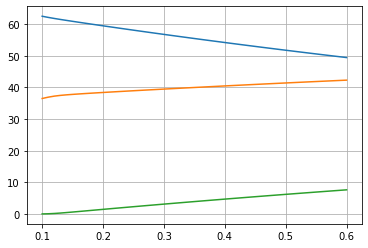

In [96]:
plt.plot(SRs, CO)
plt.plot(SRs, H2)
plt.plot(SRs, CO2)
plt.grid()
plt.show()

In [97]:
I1 = df[df['n'] == 'I-1']
ultimate = [float(I1['C']), float(I1['H']), float(I1['O']), float(I1['N']), float(I1['S']), float(I1['Cl'])]
ash = float(I1['ash']) / 100
HHV = HHV_correlation(ultimate, ash)
feed = fs.create_fuel_stream(1, ultimate, ash, moisture=0, HHV=HHV)

P = 24*ct.one_atm
T0 = 230+273.15
steamRatio = 0.314
steam = fs.create_steam_stream(steamRatio * feed.get_mass())
ORs = np.arange(0.5, 0.9+1E-9, 0.01)

CO = np.zeros_like(ORs)
H2 = np.zeros_like(ORs)
CO2 = np.zeros_like(ORs)

for i, oxy in enumerate(ORs):
    oxygen = fs.create_O2_stream(oxy * feed.get_mass())
    agent = fs.combine_streams(oxygen, steam)
    outlet = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    CO[i] = 100*outlet.get_syngas_fraction('CO', water=False, nitrogen=True)
    H2[i] = 100*outlet.get_syngas_fraction('H2', water=False, nitrogen=True)
    CO2[i] = 100*outlet.get_syngas_fraction('CO2', water=False, nitrogen=True)

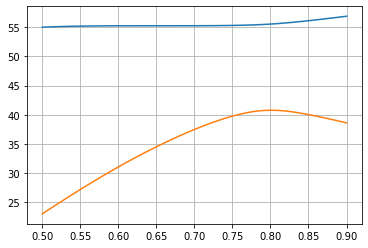

In [98]:
plt.plot(ORs, CO)
plt.plot(ORs, H2)
# plt.plot(ORs, CO2)
plt.grid()
plt.show()